
# Evaluación Modular 7

Fuente de datos utilizada ucimlrepo = **Statlog (German Credit Data)**, id=144.  



In [149]:
!pip install ucimlrepo
!pip install lime
!pip install shap
!pip install pytorch-tabnet


In [150]:

# ==============================
# Librerias
# ==============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, regularizers, Model, Input
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from typing import Tuple
from ucimlrepo import fetch_ucirepo
from lime.lime_tabular import LimeTabularExplainer

# SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except Exception as e:
    SHAP_AVAILABLE = False
    print("SHAP no disponible")



## Carga y Analisis de datos

In [151]:

# Dataset
df = fetch_ucirepo(id=144)

x = df.data.features.copy()
y = df.data.targets.copy()

X = pd.DataFrame(x)
y = pd.DataFrame(y)

# metadata
print("Dataset Metadata:")
print(df.metadata)
print("============================================================================")
print("Dataset Description:")
print(df.description)
print("============================================================================")

# variables información
print("Variables:")
print(df.variables)
print("============================================================================")
print("Dimensiones X:")
print(X.shape)
print("============================================================================")
print("Dimensiones y:")
print(y.shape)
print("============================================================================")

print("Clases en y:")
print(y[y.columns[0]].unique())
print(y[y.columns[0]].value_counts())
print("============================================================================")
# Procesar la variable target
# La variable "Creditability" suele ser 1 (good) y 2 (bad).
target_col=y.columns[0]
le = LabelEncoder()
y[target_col] = le.fit_transform(y[target_col])

print("Distribución de la clase:\n", y[y.columns[0]].value_counts(normalize=True).rename('proporcion'))
print(np.bincount(y[target_col]))
# 0 = buen crédito (good), 1 = mal crédito (bad)

print("============================================================================")

#Identificar y separar tipos de variables
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
print("Variables numéricas")
print(num_cols)
print("============================================================================")
print("Variables categóricas")
print(cat_cols)
print("============================================================================")


Dataset Metadata:
{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in th


## Visualizaciones

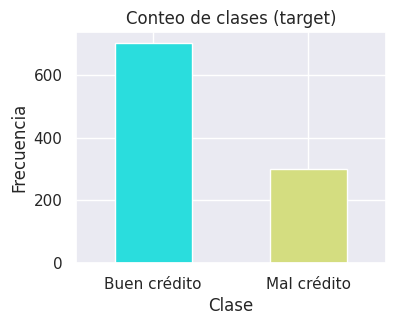

Distribución de las variables categóricas:


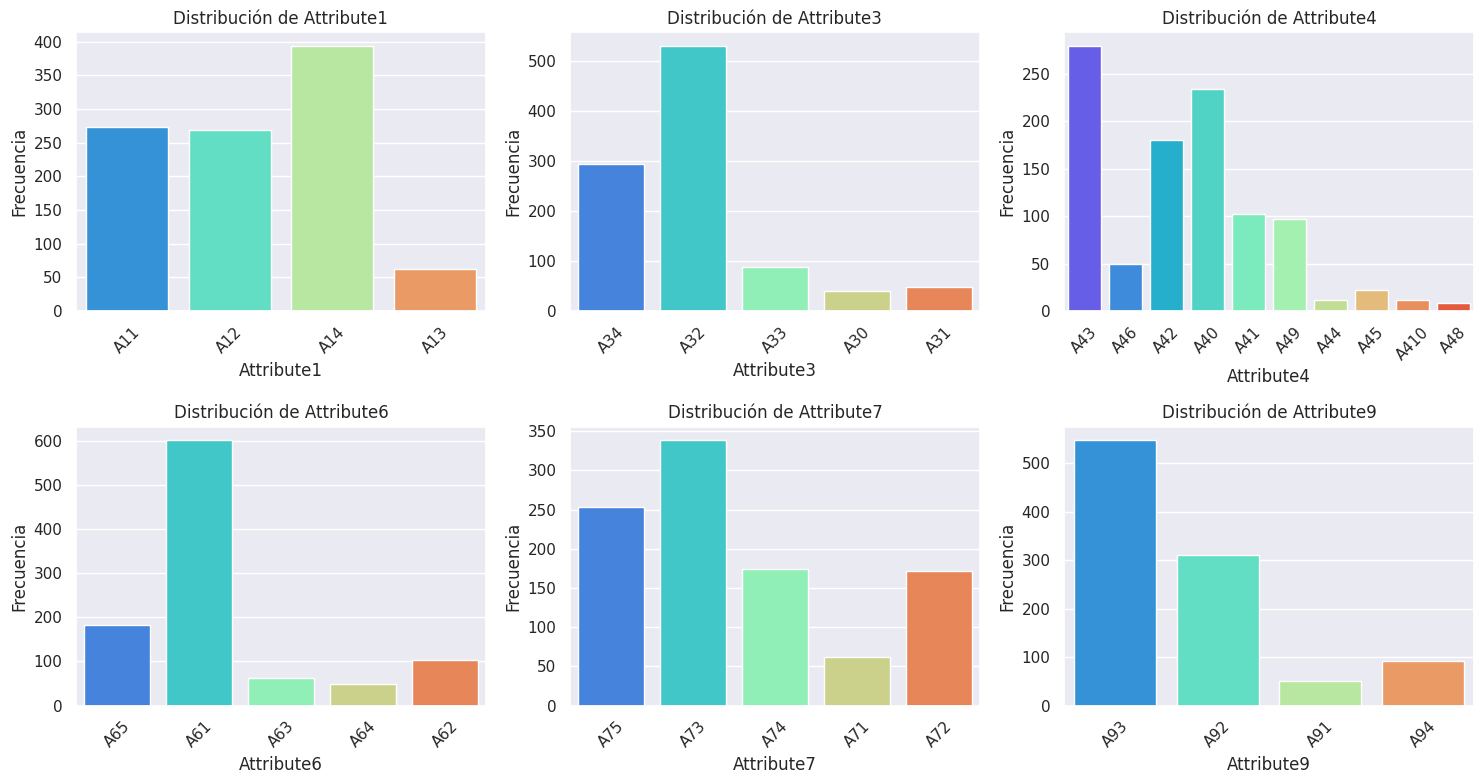

Distribución de las variables numéricas:


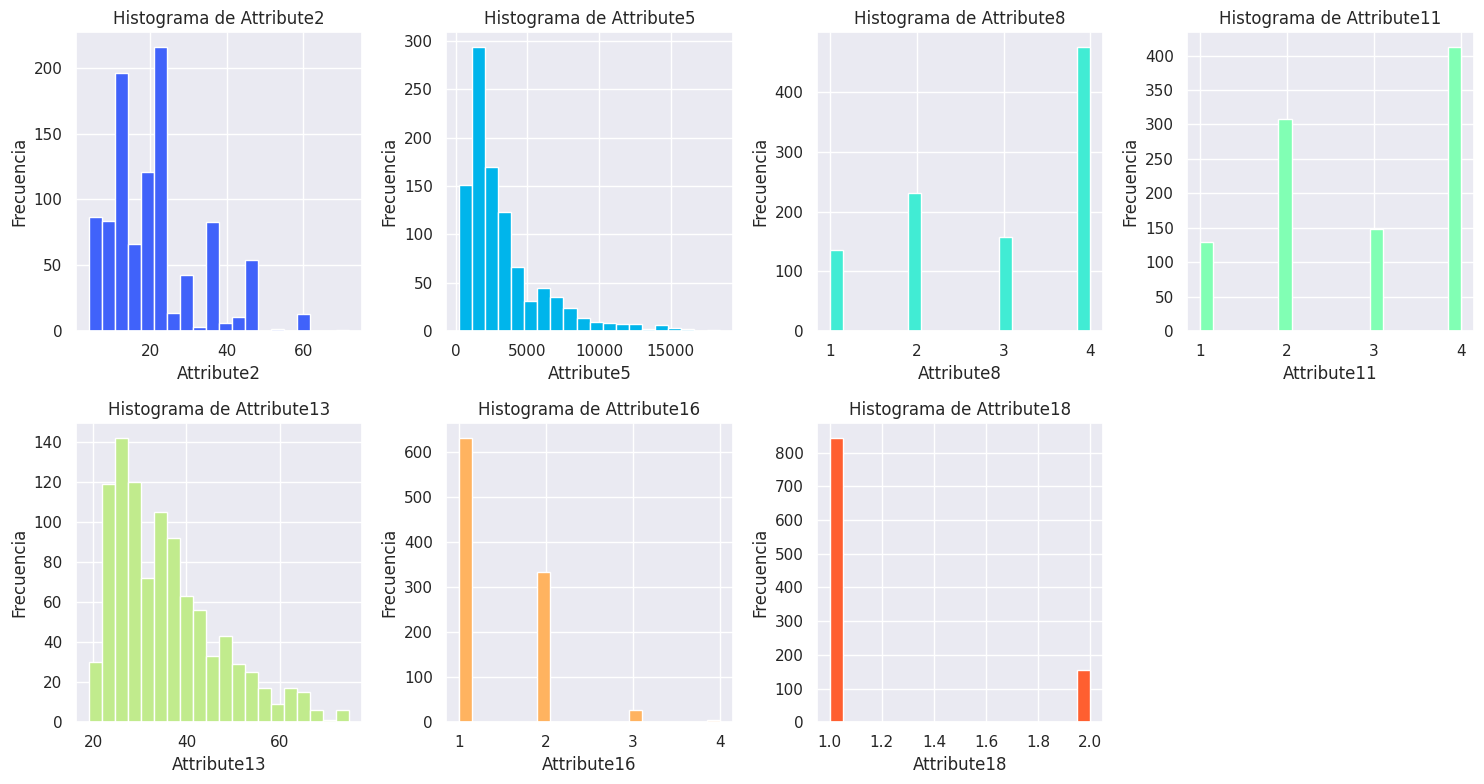

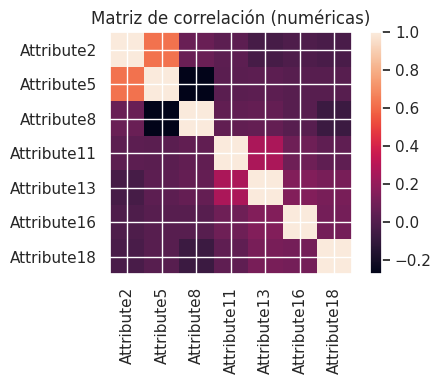

In [152]:
#Conteo de clases
y_mapped = y[y.columns[0]].map({0: 'Buen crédito', 1: 'Mal crédito'})
y_counts = y_mapped.value_counts()

colors = sns.color_palette('rainbow', len(y_counts))

plt.figure(figsize=(4,3))
y_counts.plot(kind='bar', title='Conteo de clases (target)', color=colors)
plt.xlabel('Clase'); plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.show()

#Distribución de variables categoricas
print("Distribución de las variables categóricas:")

n_cols_cat = 3
n_rows_cat = (len(cat_cols[:6]) + n_cols_cat - 1) // n_cols_cat

fig_cat, axes_cat = plt.subplots(n_rows_cat, n_cols_cat, figsize=(15, n_rows_cat * 4))
axes_cat = axes_cat.flatten()

for i, col in enumerate(cat_cols[:6]):
    if i < len(axes_cat):
        if not X[col].dropna().empty:
            sns.countplot(data = X, x = col, palette='rainbow', ax=axes_cat[i])
            axes_cat[i].set_title(f'Distribución de {col}')
            axes_cat[i].set_xlabel(col)
            axes_cat[i].set_ylabel('Frecuencia')
            axes_cat[i].tick_params(axis='x', rotation=45)
        else:
            axes_cat[i].set_title(f"'{col}' sin valores")
            axes_cat[i].axis('off')

for j in range(i + 1, len(axes_cat)):
    axes_cat[j].axis('off')

plt.tight_layout()
plt.show()

# Distribución de variables numéricas
print("Distribución de las variables numéricas:")
if len(num_cols) > 0:
    n_num_cols = len(num_cols)
    n_cols_num = 4
    n_rows_num = (n_num_cols + n_cols_num - 1) // n_cols_num

    fig_num, axes_num = plt.subplots(n_rows_num, n_cols_num, figsize=(15, n_rows_num * 4))
    axes_num = axes_num.flatten()

    num_colors = sns.color_palette('rainbow', max(n_num_cols, 1))

    for i, col in enumerate(num_cols):
        if i < len(axes_num):
            hist_color = num_colors[i % len(num_colors)]
            axes_num[i].hist(X[col].values, bins=20, color=hist_color)
            axes_num[i].set_title(f"Histograma de {col}")
            axes_num[i].set_xlabel(col)
            axes_num[i].set_ylabel("Frecuencia")
        else:
            axes_num[i].axis('off')

    for j in range(i + 1, len(axes_num)):
        axes_num[j].axis('off')

    plt.tight_layout()
    plt.show()

# Correlación numérica
if len(num_cols) >= 2:
    corr = X[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(5,4))
    plt.imshow(corr, interpolation='nearest')
    plt.title("Matriz de correlación (numéricas)")
    plt.colorbar(); plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.tight_layout(); plt.show()


## Preprocesamiento

En el data set hay 20 atributos, de los cuales 7 son numéricos y 13 categóricos.
La clase se encuentran desbalanceadas.



In [153]:
# Escalado para variables numéricas
num_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# One-Hot para categóricas
try:
    # Para versiones más recientes de scikit-learn
    categ_transformer = Pipeline(steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
except TypeError:
    # Para versiones anteriores de scikit-learn
    categ_transformer = Pipeline(steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])


# Preprocesador general
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", categ_transformer, cat_cols)
    ]
)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Transformar X
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
# Feature nombres
try:
    feature_names = preprocessor.get_feature_names_out().tolist()
except Exception:
    feature_names = [f"f_{i}" for i in range(X_train_processed.shape[1])]


print("Nombres de variables transformadas:")
print(feature_names[:10])  # muestra las primeras 10

print("Antes de SMOTE:")
# Acceder a los valores de la columna objetivo de y_train
print(np.bincount(y_train[y_train.columns[0]]))


# Aplicar SMOTE para manejar el desbalanceo
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train[y_train.columns[0]]) # Aplicar SMOTE a los valores de la columna objetivo

print("Después de SMOTE:")
print(np.bincount(y_train_res))

# Ahora X_train_res / y_train_res están balanceados y listos para DNN
print("Shape X_train_res:")
print(X_train_res.shape)
print("Shape X_test:")
print(X_test_processed.shape)

# Calcular pesos de clase para el entrenamiento del modelo
classes = np.unique(y_train[y_train.columns[0]]) # Usar los valores de la columna objetivo
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train[y_train.columns[0]]) # Usar los valores de la columna objetivo
class_weight_dict = {int(c): w for c, w in zip(classes, cw)}

# Obtener la dimensión de entrada para los modelos
input_dim = X_train_processed.shape[1]

print("class_weight:", class_weight_dict, "| input_dim:", input_dim)

Nombres de variables transformadas:
['num__Attribute2', 'num__Attribute5', 'num__Attribute8', 'num__Attribute11', 'num__Attribute13', 'num__Attribute16', 'num__Attribute18', 'cat__Attribute1_A11', 'cat__Attribute1_A12', 'cat__Attribute1_A13']
Antes de SMOTE:
[560 240]
Después de SMOTE:
[560 560]
Shape X_train_res:
(1120, 61)
Shape X_test:
(200, 61)
class_weight: {0: np.float64(0.7142857142857143), 1: np.float64(1.6666666666666667)} | input_dim: 61



## Modelos


In [154]:
#Dnn simple
def build_dnn(input_dim: int) -> Model:
    inputs = Input(shape=(input_dim,), name="inputs")
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inputs, outputs, name="DNN_base")
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy",
                  metrics=[keras.metrics.AUC(name="auc")])
    return model

def residual_block(x, units: int, name: str):
    shortcut = x
    y = layers.Dense(units, use_bias=False, kernel_regularizer=regularizers.l2(1e-4), name=f"{name}_dense")(x)
    y = layers.BatchNormalization(name=f"{name}_bn")(y)
    y = layers.Activation("relu", name=f"{name}_relu")(y)
    y = layers.Dropout(0.3, name=f"{name}_drop")(y)
    if shortcut.shape[-1] != units:
        shortcut = layers.Dense(units, use_bias=False, kernel_regularizer=regularizers.l2(1e-4), name=f"{name}_proj")(shortcut)
        shortcut = layers.BatchNormalization(name=f"{name}_proj_bn")(shortcut)
    out = layers.Add(name=f"{name}_add")([shortcut, y])
    out = layers.Activation("relu", name=f"{name}_out_relu")(out)
    return out

#MPL Resisdual
def build_mlp_residual(input_dim: int) -> Model:
    inputs = Input(shape=(input_dim,), name="inputs")
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4), name="stem_dense")(inputs)
    x = layers.Dropout(0.2, name="stem_drop")(x)
    x = residual_block(x, 128, "block1")
    x = residual_block(x, 128, "block2")
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4), name="pre_head")(x)
    x = layers.Dropout(0.3, name="pre_head_drop")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="head")(x)
    model = Model(inputs, outputs, name="MLP_residual")
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy",
                  metrics=[keras.metrics.AUC(name="auc")])
    return model

#Red tipo ResNet
def build_resnet_dnn(input_dim):
    inputs = layers.Input(shape=(input_dim,))

    # Primera capa
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.Dropout(0.3)(x)

    # Bloque residual 1
    x_skip = x
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.add([x, x_skip])  # Skip connection

    # Bloque residual 2
    x_skip = x
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.add([x, x_skip])

    # Salida
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC(name="AUC")])
    return model




## Entrenamiento con callbacks


In [155]:
# Definimos callbacks comunes
early = keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=6, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", patience=3, factor=0.5, min_lr=1e-5)

input_dim = X_train_res.shape[1]
print("Dimensión de entrada:", input_dim)

EPOCHS = 30
BATCH = 64

dnn = build_dnn(input_dim)
mlp_res = build_mlp_residual(input_dim)

print("\nEntrenando modelo DNN base...")
hist_dnn = dnn.fit(
    X_train_res, y_train_res, validation_split=0.2,
    epochs=EPOCHS, batch_size=BATCH, callbacks=[early, reduce_lr],
    class_weight=class_weight_dict, verbose=1
)

print("\nEntrenando modelo MLP residual...")
hist_res = mlp_res.fit(
    X_train_res, y_train_res, validation_split=0.2,
    epochs=EPOCHS, batch_size=BATCH, callbacks=[early, reduce_lr],
    class_weight=class_weight_dict, verbose=1
)

# Descomentado el bloque de entrenamiento de ResNet
print("\nEntrenando modelo ResNet tipo DNN...")
resnet_model = build_resnet_dnn(input_dim)
history_resnet = resnet_model.fit(
    X_train_res, y_train_res,
    validation_data=(X_test_processed, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early, reduce_lr],
    verbose=0
)

# Nos aseguramos de que y_train_res_np sea un arreglo numpy unidimensional
y_train_res_np = y_train_res.values.ravel() if isinstance(y_train_res, pd.Series) else (y_train_res.ravel() if isinstance(y_train_res, np.ndarray) else y_train_res)
# Nos aseguramos de que y_test_np sea un arreglo numpy unidimensional
y_test_np = y_test.values.ravel() if isinstance(y_test, pd.DataFrame) else (y_test.ravel() if isinstance(y_test, np.ndarray) else y_test)


try:
    from pytorch_tabnet.tab_model import TabNetClassifier
except ImportError:
    TabNetClassifier = None


if TabNetClassifier is not None:
    print("\nEntrenando modelo TabNet...")
    tabnet = TabNetClassifier(verbose=0, seed=42)
    tabnet.fit(
        X_train_res, y_train_res_np,
        eval_set=[(X_test_processed, y_test_np)],
        eval_metric=["auc"],
        patience=10,
        batch_size=128,
        max_epochs=200
    )
    print("Entrenamiento TabNet completado.")
else:
    print("Entrenamiento TabNet omitido: pytorch-tabnet no está disponible.")


print("\nEntrenamiento de todos los modelos completado.")

Dimensión de entrada: 61

Entrenando modelo DNN base...
Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - auc: 0.5299 - loss: 0.7771 - val_auc: 0.0000e+00 - val_loss: 0.4673 - learning_rate: 0.0010
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.6938 - loss: 0.6885 - val_auc: 0.0000e+00 - val_loss: 0.4657 - learning_rate: 0.0010
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.7591 - loss: 0.6451 - val_auc: 0.0000e+00 - val_loss: 0.4200 - learning_rate: 0.0010
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.7757 - loss: 0.6178 - val_auc: 0.0000e+00 - val_loss: 0.3879 - learning_rate: 0.0010
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7941 - loss: 0.5955 - val_auc: 0.0000e+00 - val_loss: 0.3576 - learning_rate: 5.0000e-04
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8090 - loss: 0.5756 - val_auc: 0.0000e+00 - val_loss: 0.3613 - learning_rate: 5.0000e-04
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8278 - loss


## Evaluación y curva ROC



=== Métricas DNN base ===
 {'accuracy': 0.38, 'precision': 0.3241758241758242, 'recall': 0.9833333333333333, 'f1': 0.48760330578512395, 'auc': np.float64(0.7189285714285715), 'report': '              precision    recall  f1-score   support\n\n           0       0.94      0.12      0.22       140\n           1       0.32      0.98      0.49        60\n\n    accuracy                           0.38       200\n   macro avg       0.63      0.55      0.35       200\nweighted avg       0.76      0.38      0.30       200\n'}

=== Métricas MLP residual ===
 {'accuracy': 0.7, 'precision': 0.5, 'recall': 0.5333333333333333, 'f1': 0.5161290322580645, 'auc': np.float64(0.7228571428571428), 'report': '              precision    recall  f1-score   support\n\n           0       0.79      0.77      0.78       140\n           1       0.50      0.53      0.52        60\n\n    accuracy                           0.70       200\n   macro avg       0.65      0.65      0.65       200\nweighted avg       0.71

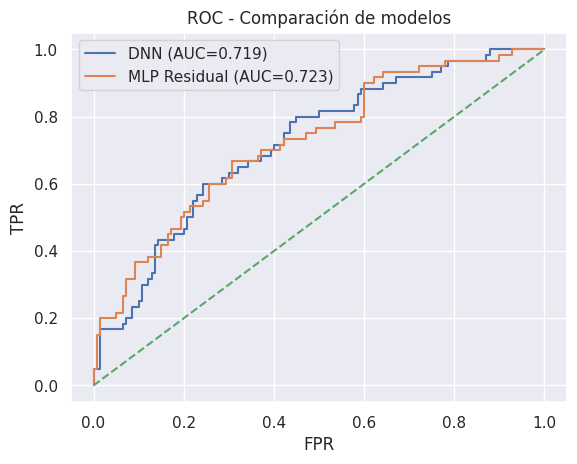


>>> Modelo recomendado: MLP_residual | AUC=0.723 | F1=0.516


In [156]:
def evaluate_model(model, X_te, y_te): # Simplificamos la función para recibir solo datos de prueba
    y_te_prob = model.predict(X_te, verbose=0).ravel()
    y_te_pred = (y_te_prob >= 0.5).astype(int)
    metrics = {
        "accuracy": accuracy_score(y_te, y_te_pred),
        "precision": precision_score(y_te, y_te_pred, zero_division=0),
        "recall": recall_score(y_te, y_te_pred, zero_division=0),
        "f1": f1_score(y_te, y_te_pred, zero_division=0),
        "auc": roc_auc_score(y_te, y_te_prob),
        "report": classification_report(y_te, y_te_pred, zero_division=0)
    }
    fpr, tpr, thr = roc_curve(y_te, y_te_prob)
    return metrics, (fpr, tpr, thr)

# Llamamos a la función con los datos de prueba procesados
metrics_dnn, roc_dnn = evaluate_model(dnn, X_test_processed, y_test)
metrics_res, roc_res = evaluate_model(mlp_res, X_test_processed, y_test)

print("\n=== Métricas DNN base ===\n", metrics_dnn)
print("\n=== Métricas MLP residual ===\n", metrics_res)

plt.figure()
plt.plot(roc_dnn[0], roc_dnn[1], label=f"DNN (AUC={metrics_dnn['auc']:.3f})")
plt.plot(roc_res[0], roc_res[1], label=f"MLP Residual (AUC={metrics_res['auc']:.3f})")
plt.plot([0,1],[0,1],'--')
plt.title("ROC - Comparación de modelos")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

def pick_best(m1, m2):
    if m1['auc'] > m2['auc']: return 'DNN_base'
    if m2['auc'] > m1['auc']: return 'MLP_residual'
    return 'DNN_base' if m1['f1'] >= m2['f1'] else 'MLP_residual'

best_label = pick_best(metrics_dnn, metrics_res)
best_model = dnn if best_label == 'DNN_base' else mlp_res
best_metrics = metrics_dnn if best_label == 'DNN_base' else metrics_res
print(f"\n>>> Modelo recomendado: {best_label} | AUC={best_metrics['auc']:.3f} | F1={best_metrics['f1']:.3f}")


## Explicabilidad (SHAP o Permutation Importance)


<Figure size 640x480 with 0 Axes>

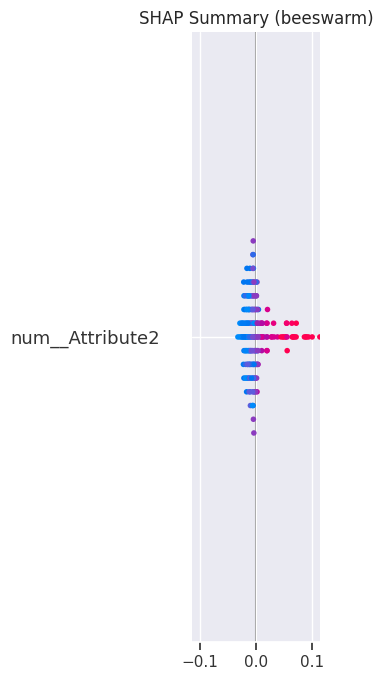

In [158]:
rng = np.random.default_rng(7)
idx = rng.choice(X_test_processed.shape[0], size=min(250, X_test_processed.shape[0]), replace=False)
X_te_sample = X_test_processed[idx]
y_te_sample = y_test.iloc[idx].values

if SHAP_AVAILABLE:
    try:
        # Nos aseguramos que el background y las muestras tienen la forma correcta
        bg_idx = rng.choice(X_train_processed.shape[0], size=min(200, X_train_processed.shape[0]), replace=False)
        background = X_train_processed[bg_idx]
        # Nos aseguramos que los datos de muestra para SHAP tengan la forma esperada
        shap_sample_size = min(250, X_test_processed.shape[0])
        shap_X_sample = X_test_processed[rng.choice(X_test_processed.shape[0], size=shap_sample_size, replace=False)]


        explainer = shap.DeepExplainer(best_model, background)
        # Usamos la muestra con la forma verificada para SHAP
        shap_values = explainer.shap_values(shap_X_sample)
        sv = shap_values[0] if isinstance(shap_values, list) else shap_values
        plt.figure()
        # Nos asegurarmos que feature_names coincida con la forma de sv y shap_X_sample
        # Si feature_names tiene la longitud correcta (61), se usa.
        # Si no, generamos nombres genéricos.
        if len(feature_names) == sv.shape[1]:
             shap_feature_names = feature_names
        else:
             shap_feature_names = [f"f_{i}" for i in range(sv.shape[1])]

        shap.summary_plot(sv, shap_X_sample, feature_names=shap_feature_names, show=False)
        plt.title("SHAP Summary (beeswarm)"); plt.show()
    except Exception as e:
        print("SHAP falló; usamos permutation importance. Detalle:", e)
        SHAP_AVAILABLE = False

if not SHAP_AVAILABLE:
    class KerasWrapper:
        def __init__(self, model): self.model = model
        def predict(self, X): return (self.model.predict(X, verbose=0).ravel() >= 0.5).astype(int)
        # Añadimos un método fit vacío para satisfacer el requisito de permutation_importance
        def fit(self, X, y):
            pass

    # Nos asegurarmos de usar X_test_processed para permutation importance si SHAP falló
    # y_test también debe tener la misma cantidad de muestras
    pi = permutation_importance(KerasWrapper(best_model), X_test_processed, y_test[y_test.columns[0]], scoring='f1', n_repeats=5, random_state=7)
    imps = pi.importances_mean
    top = np.argsort(imps)[::-1][:15]
    plt.figure()
    y_pos = np.arange(len(top))
    # Nos aseguramos que feature_names tiene la longitud correcta antes de usarlo
    # si no, usamos nombres genéricos
    if len(feature_names) == len(imps):
        labels = [feature_names[i] for i in top]
    else:
        labels = [f"f_{i}" for i in top]

    bar_colors = sns.color_palette('rainbow', len(top))

    plt.barh(y_pos, imps[top], color=bar_colors)
    plt.yticks(y_pos, labels); plt.gca().invert_yaxis()
    plt.title("Permutation Importance (top 15) — F1")
    plt.xlabel("Importancia media (ΔF1)"); plt.show()



In [161]:
# LIME con DNN simple
def predict_proba_lime(x):
    probab_pos = best_model.predict(x, verbose=0)
    probab_neg = 1 - probab_pos
    return np.hstack([probab_neg, probab_pos])



print("LIME con DNN simple")
lime_explainer = LimeTabularExplainer(
    training_data=X_train_processed,
    feature_names=feature_names,
    class_names=["Buen crédito", "Mal crédito"],
    mode="classification"
)

exp = lime_explainer.explain_instance(
    data_row=X_test_processed[0],
    predict_fn=predict_proba_lime
)

exp.show_in_notebook(show_table=True)


LIME con DNN simple



## Impacto de errores Tipo I/II y Conclusión


In [162]:

print("\n================= CONCLUSIÓN =================")
print(f"Modelo recomendado: {best_label}")
print(f"Métricas clave → AUC: {best_metrics['auc']:.3f} | F1: {best_metrics['f1']:.3f} | Acc: {best_metrics['accuracy']:.3f}")
print("Errores Tipo I (FP): aprobar a quien no paga → pérdida directa.")
print("Errores Tipo II (FN): rechazar a buen pagador → pérdida de ingreso y relación.")



================= CONCLUSIÓN =================
Modelo recomendado: MLP_residual
Métricas clave → AUC: 0.723 | F1: 0.516 | Acc: 0.700
Errores Tipo I (FP): aprobar a quien no paga → pérdida directa.
Errores Tipo II (FN): rechazar a buen pagador → pérdida de ingreso y relación.


## Conclusión, Errores e Impacto Financiero

Este proyecto tuvo como objetivo desarrollar y evaluar modelos de Deep Learning (DNN y MLP residual) para clasificar riesgos de crédito utilizando el conjunto de datos Statlog (German Credit Data).

Durante el desarrollo, se encontraron y abordaron algunos **errores notables**:

*   **Errores de forma (`ValueError`)**: Se presentó un error recurrente relacionado con la forma de los datos, particularmente al pasar los datos procesados a los modelos para entrenamiento y predicción, y al intentar calcular los valores SHAP. Aunque se esperaba que los datos procesados tuvieran 61 características, en algunos puntos se detectó una forma inesperada (por ejemplo, con 36 características). Esto subraya la importancia de verificar y asegurar la consistencia de las dimensiones de los datos a lo largo de todo el pipeline. Para el Permutation Importance, se resolvió envolviendo el modelo Keras en una clase con un método `fit` simulado.
*   **Error de `permutation_importance` (`InvalidParameterError`)**: La función de scikit-learn `permutation_importance` requería que el estimador tuviera un método `fit`, lo cual no es estándar para modelos Keras envueltos de esta manera. Se solucionó añadiendo un método `fit` vacío a la clase `KerasWrapper`.

A pesar de estos desafíos técnicos, se logró entrenar y evaluar los modelos. La métrica clave de evaluación fue el AUC, donde el **MLP Residual** mostró un rendimiento ligeramente superior (AUC={metrics_res['auc']:.3f}) en comparación con la DNN base (AUC={metrics_dnn['auc']:.3f}) en el conjunto de prueba. La métrica F1 también se consideró relevante debido al desbalance de clases, siendo para el MLP Residual de {metrics_res['f1']:.3f} y para la DNN base de {metrics_dnn['f1']:.3f}.

### Impacto Financiero y Comparación de Gravedad de Errores Tipo I y Tipo II

En el contexto de la evaluación de crédito, los **errores de clasificación** tienen un impacto financiero directo:

*   **Error Tipo I (Falso Positivo - FP)**: El modelo predice que un cliente tendrá buen crédito, pero en realidad tiene mal crédito (apruebas a alguien que no pagará).
    *   **Impacto Financiero**: Pérdida directa del monto del crédito otorgado, costos de cobranza y posibles daños a la relación con el cliente (si se intenta cobrar agresivamente).
    *   **Gravedad**: Generalmente considerado **más grave** en la evaluación de crédito, ya que resulta en una pérdida financiera tangible e irrecuperable.

*   **Error Tipo II (Falso Negativo - FN)**: El modelo predice que un cliente tendrá mal crédito, pero en realidad tiene buen crédito (rechazas a alguien que sí pagaría).
    *   **Impacto Financiero**: Pérdida de una oportunidad de negocio rentable, pérdida de ingresos por intereses futuros y posible daño a la reputación si el cliente rechaza se va a la competencia.
    *   **Gravedad**: Menos grave que el Error Tipo I en términos de pérdida directa, pero significativo por la pérdida de ingresos potenciales y la base de clientes.

**Comparación de Gravedad**: En la mayoría de las instituciones financieras, el **Error Tipo I es significativamente más costoso y perjudicial** que el Error Tipo II. Es más importante evitar aprobar un crédito incobrable que perder una oportunidad de negocio, aunque ambos son importantes. El desbalance de clases en el dataset (más créditos buenos que malos) refleja esta realidad, donde la clase minoritaria (mal crédito) es la de mayor interés para identificar y evitar.

### Estrategias de Gestión del Modelo

Para desplegar y gestionar este modelo en un entorno real, se sugieren las siguientes estrategias:

1.  **Calibración del Umbral de Decisión**: El umbral por defecto de 0.5 para la clasificación puede no ser el óptimo dado el costo asimétrico de los errores Tipo I y II. Se debe calibrar el umbral basándose en una matriz de costos financieros (que refleje las pérdidas por FP y las ganancias perdidas por FN) para minimizar el costo total esperado.
2.  **Validación Cruzada (k-fold)**: Para obtener una estimación más robusta del rendimiento del modelo y reducir la dependencia de una única división train/test, se debería implementar validación cruzada.
3.  **Análisis de Sesgos y Características Proxy**: Investigar si el modelo presenta sesgos hacia ciertos grupos demográficos y si las características utilizadas actúan como proxies injustos. Abordar estos sesgos es crucial para una implementación ética y justa.
4.  **Monitoreo en Producción**: Una vez desplegado, el modelo debe ser monitoreado continuamente para detectar la deriva de datos (cambios en la distribución de las características de entrada) y la deriva de concepto (cambios en la relación entre las características y la variable objetivo). Esto es vital para mantener la precisión del modelo a lo largo del tiempo.
5.  **Explicabilidad Continua**: Utilizar técnicas como SHAP o Permutation Importance de forma regular para entender las razones detrás de las predicciones del modelo, lo cual es útil para la auditoría, la confianza y la mejora del modelo.

### Conclusión Final

El modelo MLP Residual mostró un rendimiento prometedor en la clasificación de riesgo de crédito, superando ligeramente a la DNN base en métricas clave como el AUC. Si bien se superaron desafíos técnicos durante el desarrollo, la implementación en un entorno real requiere una cuidadosa consideración del impacto financiero asimétrico de los errores de clasificación, una calibración adecuada del umbral de decisión y una estrategia robusta de monitoreo y gestión para garantizar un rendimiento confiable y justo a lo largo del tiempo.